In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

The history saving thread hit an unexpected error (OperationalError('no such table: history',)).History will not be written to the database.


In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =5e-25

nband = 80

ng =5

ng_adju = (/ -1 /) 

ng_refs = (/ 2 , 3 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 100 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 720

data w_diffuse
     &     /1.55 , 1.6 , 1.66 , 1.66,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

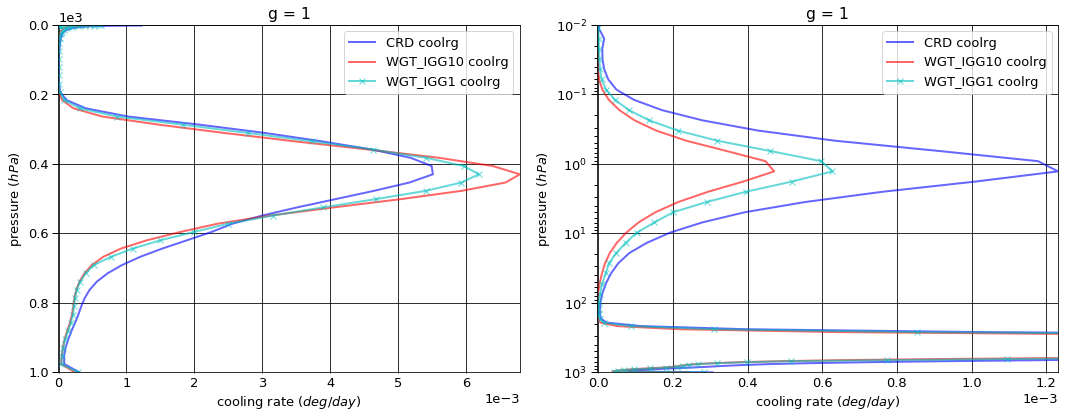

# Figure: cooling rate g-group 2

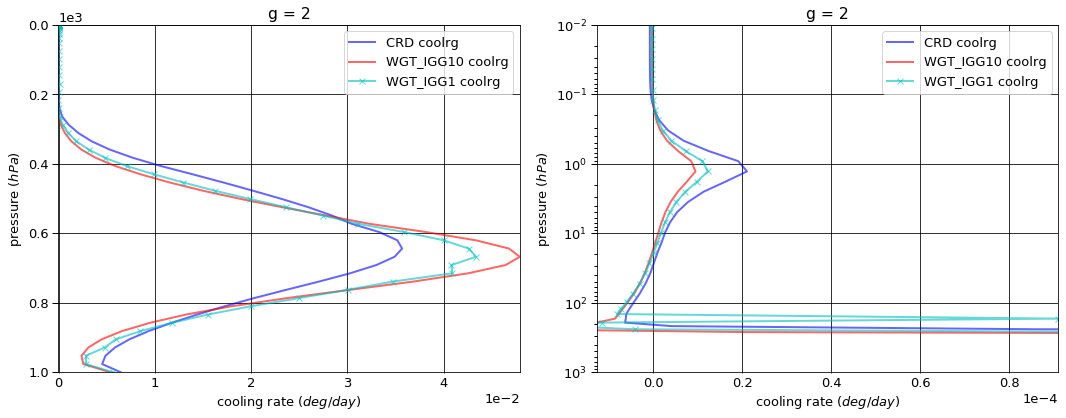

# Figure: cooling rate g-group 3

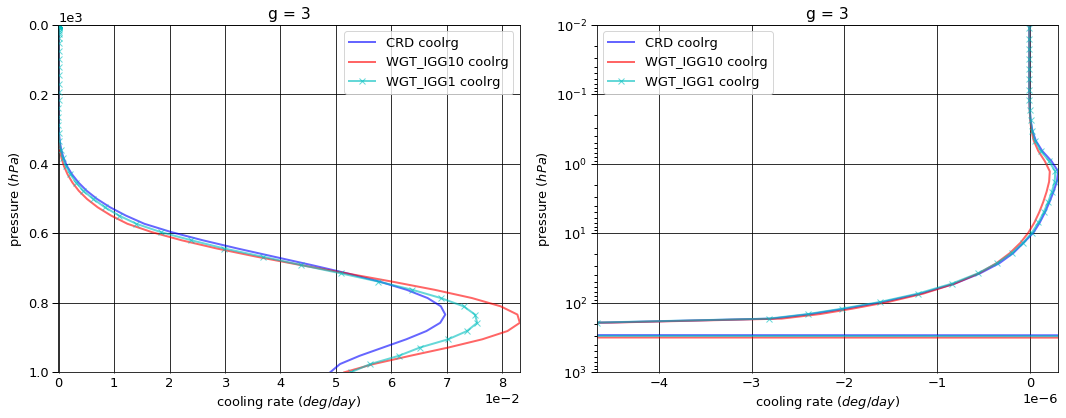

# Figure: cooling rate g-group 4

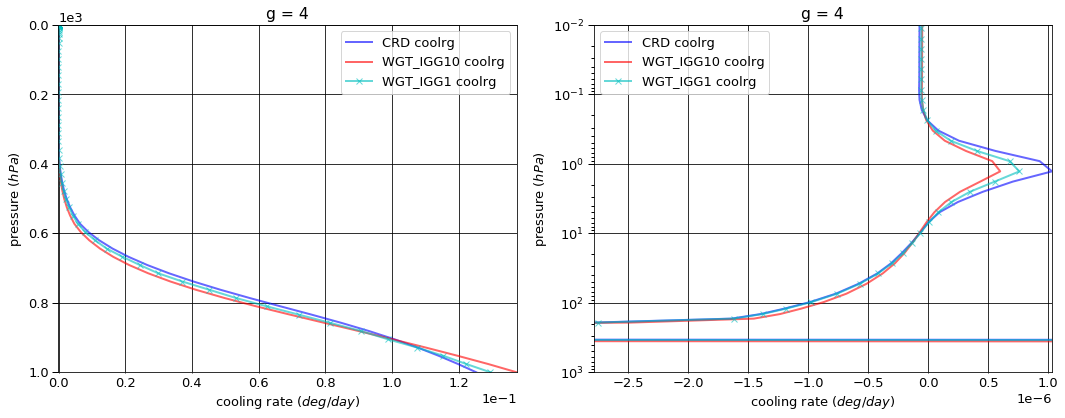

# Figure: cooling rate g-group 5

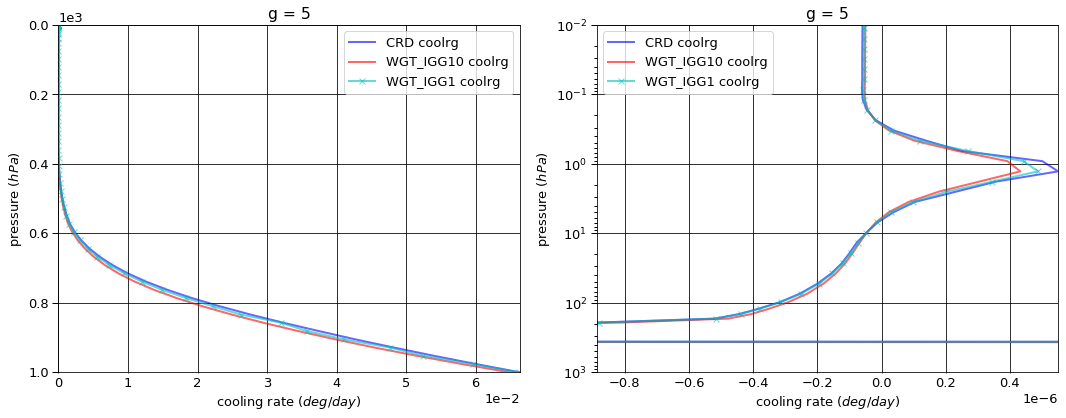

# Figure: cooling rate g-group total

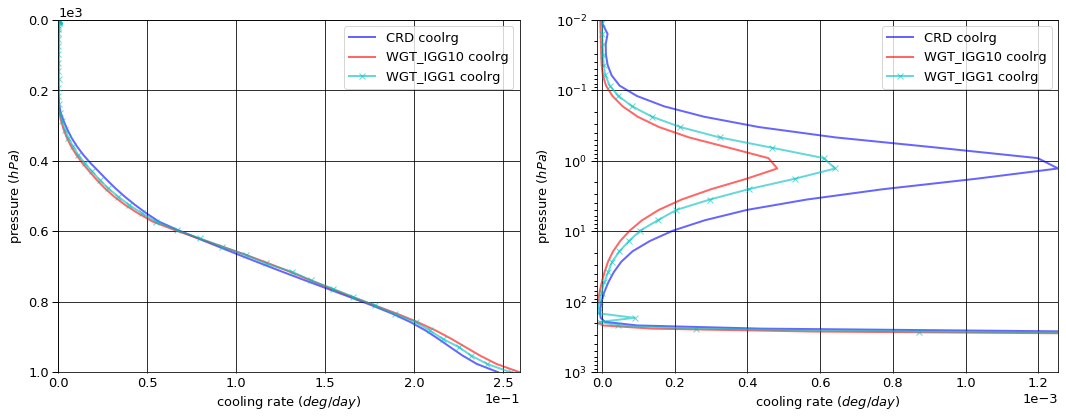

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.187950  0.000000  -0.187950
  1013.0   76     -0.356362  0.355458  -0.000903
2 0.0      1      -1.606466  0.000000  -1.606466
  1013.0   76     -2.269424  2.197506  -0.071917
3 0.0      1      -3.450958  0.000000  -3.450958
  1013.0   76     -3.989539  3.380200  -0.609339
4 0.0      1      -8.817514  0.000000  -8.817514
  1013.0   76     -9.212505  3.700282  -5.512223
5 0.0      1     -16.677215  0.000000 -16.677215
  1013.0   76    -16.809714  1.479187 -15.330527


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.187631  0.000000  -0.187631
  1013.0   76     -0.356362  0.355730  -0.000632
2 0.0      1      -1.631003  0.000000  -1.631003
  1013.0   76     -2.269424  2.251203  -0.018221
3 0.0      1      -3.460219  0.000000  -3.460219
  1013.0   76     -3.989539  3.597159  -0.392380
4 0.0      1      -8.868490  0.000000  -8.868490
  1013.0   76     -9.212505  3.518206  -5.694300
5 0.0      1     -16.691120  0.000000 -16.691120
  1013.0   76    -16.809714  1.369074 -15.440640


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.186554  0.000000  -0.186554
  1013.0   76     -0.356362  0.355610  -0.000752
2 0.0      1      -1.626772  0.000000  -1.626772
  1013.0   76     -2.269424  2.249337  -0.020087
3 0.0      1      -3.457153  0.000000  -3.457153
  1013.0   76     -3.989539  3.485397  -0.504142
4 0.0      1      -8.840584  0.000000  -8.840584
  1013.0   76     -9.212505  3.587569  -5.624937
5 0.0      1     -16.682414  0.000000 -16.682414
  1013.0   76    -16.809714  1.436906 -15.372808


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000319  0.000000  0.000319
  1013.0   76     0.000000  0.000272  0.000272
2 0.0      1     -0.024538  0.000000 -0.024538
  1013.0   76     0.000000  0.053697  0.053697
3 0.0      1     -0.009261  0.000000 -0.009261
  1013.0   76     0.000000  0.216959  0.216959
4 0.0      1     -0.050975  0.000000 -0.050975
  1013.0   76     0.000000 -0.182076 -0.182076
5 0.0      1     -0.013905  0.000000 -0.013905
  1013.0   76     0.000000 -0.110114 -0.110113


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001396  0.000000  0.001396
  1013.0   76     0.000000  0.000151  0.000151
2 0.0      1     -0.020306  0.000000 -0.020306
  1013.0   76     0.000000  0.051831  0.051831
3 0.0      1     -0.006195  0.000000 -0.006195
  1013.0   76     0.000000  0.105197  0.105197
4 0.0      1     -0.023070  0.000000 -0.023070
  1013.0   76     0.000000 -0.112714 -0.112714
5 0.0      1     -0.005199  0.000000 -0.005199
  1013.0   76     0.000000 -0.042281 -0.042281

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.679635e-06
  1001.112500 75     3.061213e-04
2 0.000312    1     -7.855162e-07
  1001.112500 75     6.458437e-03
3 0.000312    1     -6.550447e-09
  1001.112500 75     4.896847e-02
4 0.000312    1     -6.693344e-08
  1001.112500 75     1.252964e-01
5 0.000312    1     -5.658241e-08
  1001.112500 75     6.635914e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -8.886644e-06
  1001.112500 75     2.403340e-04
2 0.000312    1     -2.677278e-07
  1001.112500 75     5.398458e-03
3 0.000312    1     -5.385656e-09
  1001.112500 75     5.150896e-02
4 0.000312    1     -4.582311e-08
  1001.112500 75     1.374495e-01
5 0.000312    1     -4.779244e-08
  1001.112500 75     6.487270e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -6.603922e-06
  1001.112500 75     2.830613e-04
2 0.000312    1     -2.954336e-07
  1001.112500 75     5.599278e-03
3 0.000312    1     -5.829958e-09
  1001.112500 75     5.266429e-02
4 0.000312    1     -5.173112e-08
  1001.112500 75     1.295611e-01
5 0.000312    1     -5.182718e-08
  1001.112500 75     6.619681e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.207009e-06
  1001.112500 75    -6.578737e-05
2 0.000312    1      5.177885e-07
  1001.112500 75    -1.059978e-03
3 0.000312    1      1.164791e-09
  1001.112500 75     2.540488e-03
4 0.000312    1      2.111033e-08
  1001.112500 75     1.215313e-02
5 0.000312    1      8.789967e-09
  1001.112500 75    -1.486439e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      7.571260e-08
  1001.112500 75    -2.306000e-05
2 0.000312    1      4.900827e-07
  1001.112500 75    -8.591590e-04
3 0.000312    1      7.204891e-10
  1001.112500 75     3.695822e-03
4 0.000312    1      1.520232e-08
  1001.112500 75     4.264670e-03
5 0.000312    1      4.755228e-09
  1001.112500 75    -1.623270e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.740103,0.000000,-30.740103
1013.0,76,-32.637543,11.112634,-21.524909



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.838463,0.000000,-30.838463
1013.0,76,-32.637543,11.091371,-21.546172



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.793476,0.000000,-30.793476
1013.0,76,-32.637543,11.114818,-21.522725



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.09836,0.000000,-0.098360
1013.0,76,0.00000,-0.021263,-0.021263



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.053373,0.000000,-0.053373
1013.0,76,0.000000,0.002184,0.002184


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.247389



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000009
1001.112500,75,0.259470



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000007
1001.112500,75,0.254304



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.012081



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,5.864733e-07
1001.112500,75,6.915946e-03


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.010963,0.010888
2,0.069725,0.069403
3,0.122675,0.121927
4,0.282838,0.281821
5,0.513800,0.515961


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.395519e-22
2,3.410850e-24
3,3.161138e-24
4,5.001064e-25
5,3.765264e-26


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.395519e-22,NaN,0.010963,0.010888,0.010963,0.010888,100.0
2,3.410850e-24,0.024441,0.069725,0.069403,0.080687,0.080291,100.0
3,3.161138e-24,0.926789,0.122675,0.121927,0.203363,0.202218,600.0
4,5.001064e-25,0.158205,0.282838,0.281821,0.486200,0.484039,600.0
5,3.765264e-26,0.075289,0.513800,0.515961,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
